In [512]:
from __future__ import division

import math as math
import numpy as np
import scipy as scp
import pylab as pyl
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib.pyplot import imshow as imageplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [679]:
def grad_x(img, adjoint):
    sx , sy = np.shape(img)
    diff_x = np.copy(img)
    
    if adjoint==0:
        for x in range(sx):
            if x==sx-1:
                xnext=0
            else:
                xnext=x+1
            for y in range(sy):
                diff_x[x,y] = img[xnext,y]- img[x,y]
    else:
        for x in range(sx):
            if x==0:
                xprev=sx-1
            else:
                xprev=x-1
            for y in range(sy):
                diff_x[x,y] = img[xprev,y]- img[x,y]
    
    return diff_x
    
def grad_y(img, adjoint):
    sx , sy = np.shape(img)
    diff_y =  np.copy(img)

    if adjoint==0:
       
        for y in range(sy):
            if y==sy-1:
                ynext=0
            else:
                ynext=y+1
            for x in range(sx):
                diff_y[x,y] = img[x,ynext]- img[x,y]
    else:
        for y in range(sy):
            if y==0:
                yprev=sy-1
            else:
                yprev=y-1
            for x in range(sx):
                diff_y[x,y] = img[x,yprev]- img[x,y]
    
    return diff_y

def H(t,eps):
    if t > eps:
        return 1
    if -eps <= t <= eps:
        return (1/2)*(1 + t/(eps) + 1/(np.pi)*np.sin(np.pi*t/eps))
    if -eps > t:
        return 0
    
def grad_H(t,eps):
    if t > eps:
        return 0
    if -eps <= t <= eps:
        return 1/(2*eps) + 1/(2*eps)*np.cos(np.pi*t/eps)
    if -eps > t:
        return 0
######################################################################    
def in_img(phi,px):
    if 0 <= px[0] <= phi.shape[0]-1 and 0 <= px[1] <= phi.shape[1]-1:
        return True
    else:
        return False
########################################################################
def omega(phi):#fonction qui creer omega par phi 
    omg = []
    for i in range (phi.shape[0]):
        for j in range(phi.shape[1]):
            if phi[i,j] >= 0:
                omg.append([i,j])
    return omg
######################################################################
def voisinage(px,phi):#fonction qui donne le voisinage d'un pixel
    Nl = np.shape(phi)[0]
    Nc = np.shape(phi)[1]
    voisin = [[(px[0] + 1)%Nl, px[1]],
              [px[0], (px[1] + 1)%Nc],
              [(px[0] - 1)%Nl, px[1]],
              [px[0], (px[1] - 1)%Nc],]
    real_voisin = []
    for v in voisin:
        if in_img(phi,v):
            real_voisin.append(v)
            
    return real_voisin
########################################################################
def dl(px1,px2): 
    if abs(px1[0] - px2[0]) + abs(px1[1] - px2[1]) == 1:
        return 1
    else:
        return 0   
####################################################################### 
def P(w,omg,phi,Lambda,eps): #P(Omega)
    e = 0
    tmpx = grad_x(w, 0)
    tmpy = grad_y(w, 0)
    for [m,n] in omg:
        voisin = voisinage([m,n],phi)
        for v in voisin:
            A1 = H(phi[m,n],eps)
            A2 = (1-H(phi[v[0],v[1]],eps))
            tmpx[m,n] = tmpx[m,n]*A1*A2
            tmpy[m,n] = tmpy[m,n]*A1*A2
            e += dl([m, n],v)*A1*A2
    
    dx = np.linalg.norm( tmpx, ord='fro') 
    dy = np.linalg.norm( tmpy, ord='fro')
    return e - Lambda*(dx*dx + dy*dy)
########################################################################
def E(w,Lambda):
    gx = np.linalg.norm( grad_x(w,0), ord='fro')
    gy = np.linalg.norm( grad_y(w,0), ord='fro')
    
    return Lambda*(gx*gx + gy*gy)
##############################################################################
def Mf_shah(w,u,phi,omg,Lambda,mu,eps):
    return (P(w,omg,phi,Lambda,eps)) + E(w,Lambda) + mu*np.linalg.norm(w-u)**2
##############################################################################
def grad_phi(w,phi,omg,Lambda,eps):
    grad_E_3 = np.zeros(np.shape(phi))
    
    tmpx = grad_x(w, 0)
    tmpy = grad_y(w, 0)
    for [i,j] in omg:
        for v in voisinage([i,j],phi):
            A1 = grad_H(phi[i, j], eps)
            A2 = (1 - 2 * H(phi[v[0],v[1]], eps))
            tmpx[i,j] = tmpx[i,j]*A1*A2
            tmpy[i,j] = tmpy[i,j]*A1*A2
            grad_E_3[i, j] +=dl([i, j],v)*A1*A2
                
    
    gx = np.linalg.norm( tmpx, ord='fro')
    gy = np.linalg.norm( tmpy, ord='fro')
            
    return grad_E_3  - Lambda*(gx*gx + gy*gy)
#######################################################################################################
def grad_MS(w,u,phi,omg,Lambda,mu,eps):  
    tmpx = grad_x(w, 0) 
    tmpx2 = grad_x(w, 0) 
    tmpy = grad_y(w, 0)
    tmpy2 = grad_y(w, 0) 
    for [i,j] in omg:
        for v in voisinage([i,j],phi):
            A1 = H(phi[i,j],eps)
            A2 = (1-H(phi[v[0],v[1]],eps))
            tmpx2[i,j] = tmpx2[i,j]*A1*A2
            tmpy2[i,j] = tmpy2[i,j]*A1*A2
            
    
    
    tmpx3 = tmpx - tmpx2
    tmpy3 = tmpy - tmpy2
    tmpx1 = grad_x(tmpx3, 1)
    tmpy1 = grad_y(tmpy, 1)
    grad1 = 2 * Lambda*(tmpx1 + tmpy1)

    return    grad1 + mu * 2 * (w - u)
#######################################################################################################                     
def segmentation(u,Lambda,mu,eps,itermax):
    pas_w = 0.05
    pas_phi = 0.05
    phi = np.copy(u)
    #phi = np.random.uniform(-1, 1, u.shape)
    omega_ = omega(phi)
    norm_grad_phi = []
    norm_grad_w = []
    MS = []
    w = np.copy(u)
    for it in range (itermax) :
        grad_w_= grad_MS(w, u,phi,omega_, Lambda, mu,eps)
        
        w = w - (pas_w * grad_w_)
        
        grad_phi_ = grad_phi(w, phi,omega_,Lambda, eps)
        
        phi = phi - (pas_phi * grad_phi_)
        
    
        omega_ = omega(phi)
        f = abs(Mf_shah(w,u,phi,omega_,Lambda,mu,eps))
        MS.append(f)
        print( 'iter = ', it , 'fonction = ', abs(Mf_shah(w,u,phi,omega_,Lambda,mu,eps)) ,\
              'norm_grad_w = ',np.linalg.norm(grad_w_),'norm_grad_phi = ', np.linalg.norm(grad_phi_))
    return w,phi,omega_,MS

In [680]:
img1 = 255 * mpimg.imread("image test1.png")
img3 = 255 * mpimg.imread("image test3.png")
img4 = 255 * mpimg.imread("image test4.png")
u1=img1[:,:,0]
u3=img3[:,:,0]
u4=img4[:,:,0]
#u1 + np.random.uniform(-10, 10, u1.shape)
#u2 + np.random.uniform(-10, 10, u2.shape)
#u3 + np.random.uniform(-10, 10, u3.shape)


In [681]:
Lambda = 1
mu = 0.1
eps = 0.1
itermax = 5
#w1,phi1,omega1,fonction1 = segmentation(u1,Lambda,mu,eps,itermax)
#w2,phi2,omega2,fonction2 = segmentation(u2,Lambda,mu,eps,itermax)
#w3,phi3,omega3,fonction3 = segmentation(u3,Lambda,mu,eps,itermax)
w4,phi4,omega4,fonction4 = segmentation(u4,Lambda,mu,eps,itermax)

iter =  0 fonction =  9326976.401634222 norm_grad_w =  10890.62 norm_grad_phi =  153.62291495737216
iter =  1 fonction =  6912434.138924882 norm_grad_w =  7500.9473 norm_grad_phi =  148.32396974191326
iter =  2 fonction =  5613361.003161289 norm_grad_w =  5442.9663 norm_grad_phi =  142.828568570857
iter =  3 fonction =  4841157.35912893 norm_grad_w =  4152.9717 norm_grad_phi =  137.11309200802089
iter =  4 fonction =  4338949.88747306 norm_grad_w =  3318.4902 norm_grad_phi =  131.14877048604


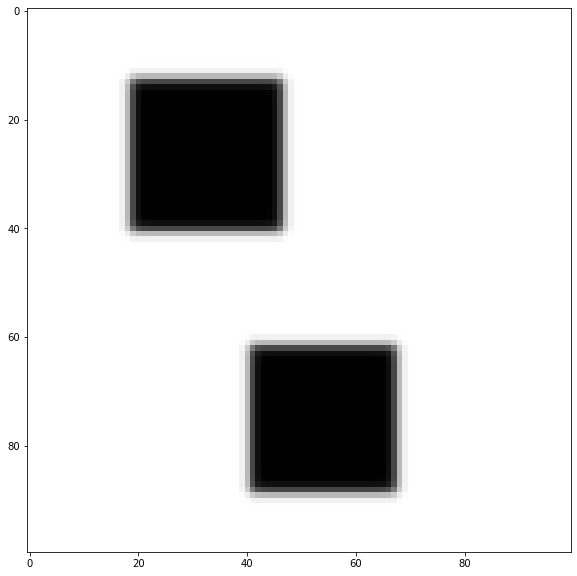

In [682]:
plt.figure(figsize = (10,10))
#plt.imshow(w1,cmap='gray')
#plt.imshow(w2,cmap='gray')
#plt.imshow(w3,cmap='gray')
plt.imshow(w4,cmap='gray')
plt.show()

In [683]:
def plot_s(phi,omega,fonction):

        for i in range(phi.shape[0]):
            for j in range(phi.shape[1]):
                if phi[i, j] > 0:
                    phi[i, j] = 255
                else:
                    phi[i, j] = 0
                    
        plt.imshow(phi)
        plt.title("omega")
        plt.show()
        
        plt.plot(fonction)
        plt.title("Mumford Shah")
        plt.show()

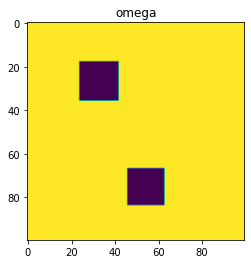

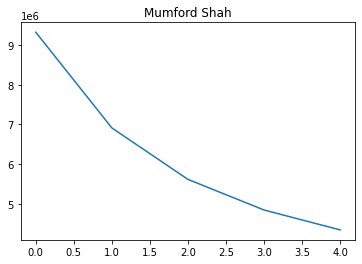

In [684]:
#plot_s(phi1,omega1,fonction1)
#plot_s(phi2,omega2,fonction2)
#plot_s(phi3,omega3,fonction3)
plot_s(phi4,omega4,fonction4)

In [685]:
print(phi4)

[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
